In [1]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

DATA_DIR = './data/'

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:21

### Metrics functions

In [2]:
def mrse(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

def re(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

## Reading Nino 1.2 data

In [3]:
filename = 'nino12_data.txt'

In [4]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [5]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [23.01, 24.32, 25.11, 23.63, 22.68, 21.33, 20.31, 20.12, 19.56, 19.99, 19.85, 21.7]
1951.0 [24.11, 25.19, 25.74, 25.29, 24.59, 24.61, 23.82, 22.18, 21.29, 21.74, 22.34, 22.8]
1952.0 [24.36, 26.02, 26.08, 24.44, 23.48, 21.93, 20.73, 19.89, 19.37, 20.37, 20.83, 22.3]
1953.0 [24.13, 26.27, 27.22, 27.0, 25.43, 23.43, 21.96, 21.18, 21.06, 20.84, 21.51, 22.2]
1954.0 [22.66, 24.88, 25.17, 22.45, 21.43, 20.66, 19.13, 19.31, 19.02, 18.98, 20.2, 21.3]
1955.0 [23.72, 24.97, 25.12, 24.3, 22.26, 21.2, 20.52, 19.46, 19.26, 19.2, 19.83, 21.1]
1956.0 [23.26, 24.9, 25.73, 24.39, 23.21, 22.19, 21.82, 20.57, 19.72, 19.82, 20.59, 21.4]
1957.0 [22.9, 26.17, 27.27, 26.66, 26.82, 25.14, 23.82, 22.2, 21.64, 21.64, 22.21, 23.4]
1958.0 [24.7, 26.36, 26.96, 26.25, 24.54, 23.1, 22.02, 20.59, 20.32, 20.82

## Filtering data to have 1950 - 2008

In [6]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [7]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [23.01, 24.32, 25.11, 23.63, 22.68, 21.33, 20.31, 20.12, 19.56, 19.99, 19.85, 21.7]
1951 [24.11, 25.19, 25.74, 25.29, 24.59, 24.61, 23.82, 22.18, 21.29, 21.74, 22.34, 22.8]
1952 [24.36, 26.02, 26.08, 24.44, 23.48, 21.93, 20.73, 19.89, 19.37, 20.37, 20.83, 22.3]
1953 [24.13, 26.27, 27.22, 27.0, 25.43, 23.43, 21.96, 21.18, 21.06, 20.84, 21.51, 22.2]
1954 [22.66, 24.88, 25.17, 22.45, 21.43, 20.66, 19.13, 19.31, 19.02, 18.98, 20.2, 21.3]
1955 [23.72, 24.97, 25.12, 24.3, 22.26, 21.2, 20.52, 19.46, 19.26, 19.2, 19.83, 21.1]
1956 [23.26, 24.9, 25.73, 24.39, 23.21, 22.19, 21.82, 20.57, 19.72, 19.82, 20.59, 21.4]
1957 [22.9, 26.17, 27.27, 26.66, 26.82, 25.14, 23.82, 22.2, 21.64, 21.64, 22.21, 23.4]
1958 [24.7, 26.36, 26.96, 26.25, 24.54, 23.1, 22.02, 20.59, 20.32, 20.82, 21.28, 22.3]
1959 [23.69, 25.63, 26.83, 25.66, 24.02, 22.5, 21.39, 19.99, 20.11, 20.72, 21.76, 22.5]
1960 [24.23, 25.68, 26.24, 24.43, 23.33, 21.71, 20.64, 19.99, 20.46, 20.11, 21.06, 22.5]
1961 [24.49, 26.56, 25.76, 24.75

## Reading Nino 1.2 Mean data

In [8]:
filename = 'nino12_means.txt'

In [9]:
mean_data = open(DATA_DIR + filename)
mean_data_dict = {}

for line in mean_data.readlines():  
    _,year,value = line.split(' ')
    value = float(value[:-2])
    year = int(float(year))
    if year in mean_data_dict:
        mean_data_dict[year]=mean_data_dict[year]+[value]
    else:
        mean_data_dict.update({year:[value]})

In [10]:
for key,value in mean_data_dict.items():
    print(key,value)
    assert len(value) == 12

1950 [23.0, 24.3, 25.1, 23.6, 22.6, 21.3, 20.3, 20.1, 19.5, 19.9, 19.8, 21.7]
1951 [24.1, 25.1, 25.7, 25.2, 24.5, 24.6, 23.8, 22.1, 21.2, 21.7, 22.3, 22.8]
1952 [24.3, 26.0, 26.0, 24.4, 23.4, 21.9, 20.7, 19.8, 19.3, 20.3, 20.8, 22.3]
1953 [24.1, 26.2, 27.2, 27.0, 25.4, 23.4, 21.9, 21.1, 21.0, 20.8, 21.5, 22.2]
1954 [22.6, 24.8, 25.1, 22.4, 21.4, 20.6, 19.1, 19.3, 19.0, 18.9, 20.2, 21.3]
1955 [23.7, 24.9, 25.1, 24.3, 22.2, 21.2, 20.5, 19.4, 19.2, 19.2, 19.8, 21.1]
1956 [23.2, 24.9, 25.7, 24.3, 23.2, 22.1, 21.8, 20.5, 19.7, 19.8, 20.5, 21.4]
1957 [22.9, 26.1, 27.2, 26.6, 26.8, 25.1, 23.8, 22.2, 21.6, 21.6, 22.2, 23.4]
1958 [24.7, 26.3, 26.9, 26.2, 24.5, 23.1, 22.0, 20.5, 20.3, 20.8, 21.2, 22.3]
1959 [23.6, 25.6, 26.8, 25.6, 24.0, 22.5, 21.3, 19.9, 20.1, 20.7, 21.7, 22.5]
1960 [24.2, 25.6, 26.2, 24.4, 23.3, 21.7, 20.6, 19.9, 20.4, 20.1, 21.0, 22.5]
1961 [24.4, 26.5, 25.7, 24.7, 23.4, 22.1, 20.4, 19.8, 19.5, 19.9, 20.9, 21.9]
1962 [23.8, 25.3, 24.3, 23.1, 22.9, 21.7, 20.6, 20.2, 19.9, 19.8

## Flattening time series data

In [11]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [12]:
assert len(filtered_ts) == (2008-1950+1)*12

In [13]:
filtered_means = np.array([])
filtered_means = np.array([np.concatenate((filtered_means,val)) for val in mean_data_dict.values()]).flatten()

In [14]:
assert len(filtered_means) == (2008-1950+1)*12

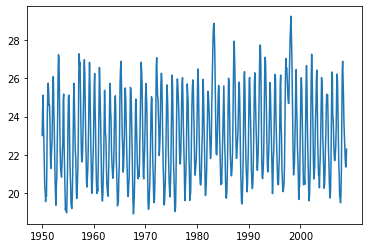

In [15]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

In [16]:
def get_data(data,years):
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

### Train Test Split

In [17]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


In [18]:
training_data = get_data(filtered_data,training_years)
training_means = get_data(mean_data_dict,training_years)

In [19]:
len(training_data),len(training_means)

(564, 564)

In [20]:
assert len(training_years)*12 == len(training_data)
assert len(training_years)*12 == len(training_means)

### Plotting training data, mean, acf and pacf

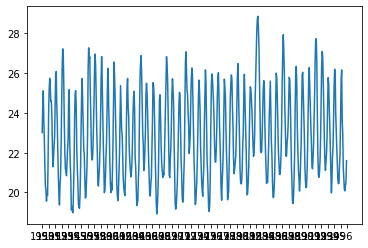

In [21]:
plt.plot(training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

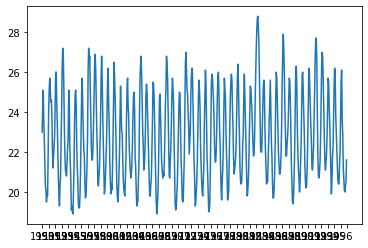

In [22]:
#plt.plot(reqd_data)
plt.plot(training_means)
plt.xticks(range(0,len(training_means)+1,12),labels=training_years)
plt.show()

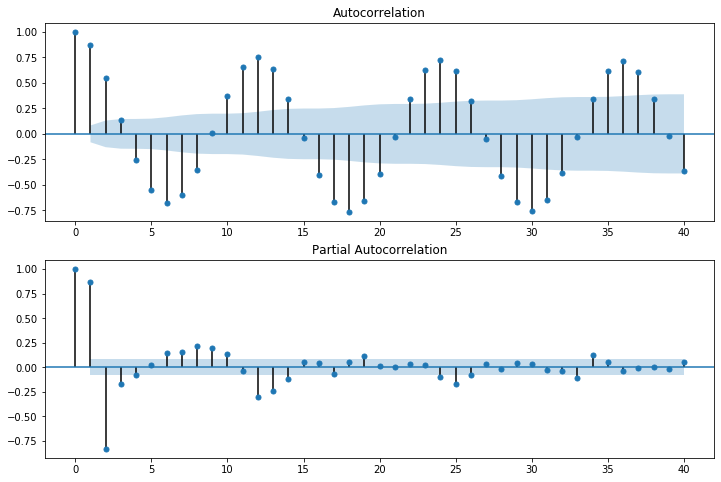

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [24]:
p=6

In [25]:
formatted_training_data = pd.Series(data=training_data-training_means,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [26]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

const      0.040751
ar.L1.y    0.019079
ar.L2.y   -0.063654
ar.L3.y   -0.021539
ar.L4.y   -0.037417
ar.L5.y    0.001422
ar.L6.y    0.053871
dtype: float64


### Getting predictions for test set

In [27]:
predictions = arma_mod.predict(start=f'{testing_years[0]}m1', end=f'{testing_years[-1]}m12', dynamic=False)
test_data = get_data(filtered_data,testing_years)
test_means = get_data(mean_data_dict,testing_years)

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


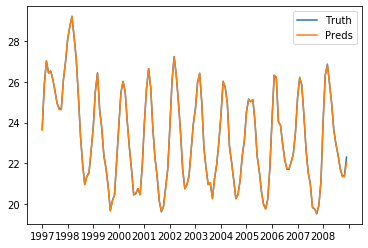

In [28]:
plt.plot(test_data,label='Truth')
plt.plot(predictions.values+test_means,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [29]:
test_mrse = mrse(test_data,predictions.values+test_means)
test_re = re(test_data,predictions.values+test_means)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

Test MRSE: 0.015149740119867833
Test RE: 0.0015034803154410704


/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  564
Model:                     ARMA(6, 3)   Log Likelihood                     nan
Method:                       css-mle   S.D. of innovations              0.528
Date:                Thu, 14 Nov 2019   AIC                                nan
Time:                        17:34:37   BIC                                nan
Sample:                             0   HQIC                               nan
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7206        nan        nan        nan         nan         nan
ar.L1.y        2.5767        nan        nan        nan         nan         nan
ar.L2.y       -2.4697        nan        nan        n

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


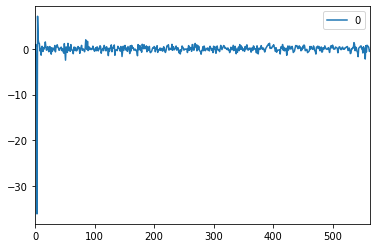

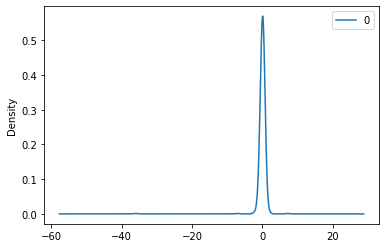

                0
count  564.000000
mean    -0.037935
std      1.672497
min    -36.108667
25%     -0.319342
50%      0.050933
75%      0.389255
max      7.131110


In [31]:
model = ARIMA(training_data, order=(6,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
# model.predict(model_fit.params,start=0,end=-1,dynamic=True)